# Competição Talking Data
## Equipe "Econometristas" - Alessandro Rivello e Raul Guarini

In [1]:
import numpy as np 
import pandas as pd 

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import pickle
import itertools
%matplotlib inline

import os

import gc, time

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'days'          : 'uint8',
        'hours'         : 'uint8',
        'minutes'       : 'uint8',
        'seconds'       : 'uint8',
        }

# Correcting path to data inside EMAp servers
path = '~/Kaggle/Dados/'

train_columns = ['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'days', 'hours', 'minutes','seconds']

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dado o tamanho dos dados originais, escolhemos trabalhar com uma amostra dos dados de teste (10% dos dados, selecionados aleatoriamente). Essa amostra é o mesmo dataset utilizado na parte de EDA do trabalho.

In [2]:
# Importing data

# Load training df (partly)
start_time = time.time()
df_train = pd.read_csv(path + '10_train_timed.csv', dtype=dtypes, usecols=train_columns)
print('Load df_train with {} seconds'.format(round(time.time() - start_time, 3)))

Load df_train with 72.641 seconds


In [3]:
# Load testing df
start_time = time.time()
df_test = pd.read_csv(path + 'test_timed.csv', dtype=dtypes)
print('Load df_test with {} seconds'.format(round(time.time() - start_time, 3)))

train_record_index = df_train.shape[0]

Load df_test with 45.641 seconds


In [4]:
df_train.head()

,ip,app,device,os,channel,days,hours,minutes,seconds,is_attributed
0,29045,64,1,13,459,6,14,54,59,0
1,64886,3,1,13,379,6,15,5,17,0
2,147605,3,1,19,379,6,15,8,24,0
3,108881,3,1,19,379,6,15,25,15,0
4,116013,3,1,13,379,6,15,39,18,0


In [5]:
df_test.head()

,click_id,ip,app,device,os,channel,days,hours,minutes,seconds
0,0,5744,9,1,3,107,10,4,0,0
1,1,119901,9,1,3,466,10,4,0,0
2,2,72287,21,1,19,128,10,4,0,0
3,3,78477,15,1,13,111,10,4,0,0
4,4,123080,12,1,13,328,10,4,0,0


In [6]:
#df for submit
df_submit = pd.DataFrame()
df_submit['click_id'] = df_test['click_id']

#Extracting learning data
Learning_Y = df_train['is_attributed']
print('Training target correctly extracted.')

#drop zone
df_test = df_test.drop(['click_id'], axis=1)
df_train = df_train.drop(['is_attributed'], axis=1)
gc.collect();

df_merge = pd.concat([df_train, df_test])
del df_train, df_test
gc.collect();
print('Data was correctly merged')

Training target correctly extracted.
Data was correctly merged


# 1. Feature de contagem 

Criaremos uma coluna para cada feature existente no dataset que contará quantos cliques estão ligados a determinado registro

In [7]:
# Count all features except device and timestamp data for both train and test df 
start_time = time.time()
columns = df_merge.columns
columns = [i for i in columns if i != 'device' and i != 'days' and i != 'hours' and i != 'minutes'
          and i != 'seconds']

for col in columns:
    df_count = df_merge[col].value_counts().reset_index(name=col+'_count')
    df_count.columns = [col, col+'_count']

    df_merge = df_merge.merge(df_count, on=col, how='left', sort=False)
    df_merge[col+'_count'] = df_merge[col+'_count'].astype('uint16')

    del df_count
    
print('Loaded counts for all features with {} seconds'.format(round(time.time() - start_time, 3)))

Loaded counts for all features with 78.797 seconds


In [8]:
df_merge.head()

,ip,app,device,os,channel,days,hours,minutes,seconds,ip_count,app_count,os_count,channel_count
0,29045,64,1,13,459,6,14,54,59,1472,58544,8424,55595
1,64886,3,1,13,379,6,15,5,17,1702,18901,8424,24734
2,147605,3,1,19,379,6,15,8,24,559,18901,32993,24734
3,108881,3,1,19,379,6,15,25,15,19887,18901,32993,24734
4,116013,3,1,13,379,6,15,39,18,948,18901,8424,24734


In [9]:
gc.collect();

df_train = df_merge[:train_record_index]
df_test = df_merge[train_record_index:]

Vamos definir algumas funções para nos ajudar a avaliar o desempenho dos nossos modelos.

In [10]:
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from matplotlib.font_manager import FontProperties
import seaborn as sns
import pickle
import itertools
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pylab import *

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def clf_eval(clf, X, y_true, classes=['Não baixou', 'Baixou'], normalize=False):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes, normalize=normalize)
    
    return roc_auc_score(y_true, y_pred)

Dado o grande desbalanceamento nos dados, visto na fase de EDA, faremos o undersampling dos dados.

In [11]:
# Doing undersampling

rus = RandomUnderSampler(return_indices=True)
X_resampled, Y_resampled, idx_resampled = rus.fit_sample(df_train, Learning_Y)

X_resampled = pd.DataFrame(X_resampled, columns=df_train.columns)
Y_resampled = pd.DataFrame(Y_resampled, columns=['is_attributed'])


In [12]:
# Separating 10 groups of testing and training for cross validation

train_idx = np.array([])
test_idx = np.array([])
roc_counts = []

idx = model_selection.StratifiedKFold(n_splits=10).split(X_resampled, Y_resampled)

In [13]:
for train_idx, test_idx in idx:
    start_time = time.time()
    X = X_resampled.iloc[train_idx]
    Y = Y_resampled.iloc[train_idx]
    rf = RandomForestClassifier(n_estimators=100, max_depth=13, verbose=0, n_jobs = -1)
    rf = rf.fit(X, Y.values.ravel())
    
    print('RandomForest has fitted X_resampled with {} seconds'.format(round(time.time() - start_time), 3))
        
    Y_true = Y_resampled.iloc[test_idx]
    Y_pred = rf.predict(X_resampled.iloc[test_idx])
    roc_counts.append(roc_auc_score(Y_true, Y_pred))

RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds


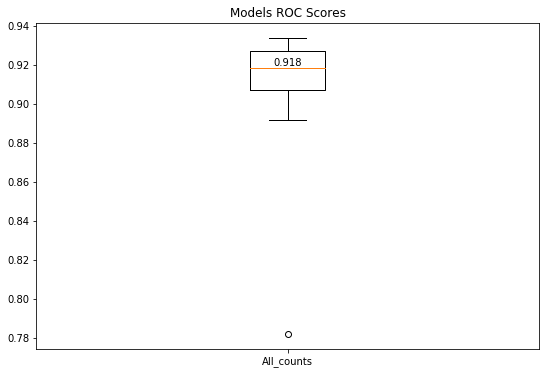

In [14]:
# Ploting the ROC scores
roc_counts = np.array(roc_counts)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

bp_dict = ax.boxplot(roc_counts)
ax.set_xticklabels(['All_counts'])
ax.set_title('Models ROC Scores')

for line in bp_dict['medians']:
    # get position data for median line
    x1, y1 = line.get_xydata()[0] # low of median line
    x2, y1 = line.get_xydata()[1] # top of median line
    x = (x1 + x2)/2
    # overlay median value
    text(x, y1+0.001, '%.3f' % y1,
         horizontalalignment='center') # draw above, centered

Buscando uma representação mais parcimoniosa tentaremos usar apenas a dado de IP count

In [15]:
# Doing undersampling

params = ['ip', 'app', 'device', 'os', 'channel','days', 'hours', 'minutes',
                                                                  'seconds', 'ip_count']
rus = RandomUnderSampler(return_indices=True)
X_resampled, Y_resampled, idx_resampled = rus.fit_sample(df_train[params], Learning_Y)

X_resampled = pd.DataFrame(X_resampled, columns=params)
Y_resampled = pd.DataFrame(Y_resampled, columns=['is_attributed'])

In [16]:
# Separating 10 groups of testing and training for cross validation

train_idx = np.array([])
test_idx = np.array([])
roc_ipcounts = []

idx = model_selection.StratifiedKFold(n_splits=10).split(X_resampled, Y_resampled)

In [17]:
for train_idx, test_idx in idx:
    start_time = time.time()
    X = X_resampled.iloc[train_idx]
    Y = Y_resampled.iloc[train_idx]
    rf = RandomForestClassifier(n_estimators=100, max_depth=13, verbose=0, n_jobs = -1)
    rf = rf.fit(X, Y.values.ravel())
    
    print('RandomForest has fitted X_resampled with {} seconds'.format(round(time.time() - start_time), 3))
        
    Y_true = Y_resampled.iloc[test_idx]
    Y_pred = rf.predict(X_resampled.iloc[test_idx])
    roc_ipcounts.append(roc_auc_score(Y_true, Y_pred))

RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds
RandomForest has fitted X_resampled with 0 seconds


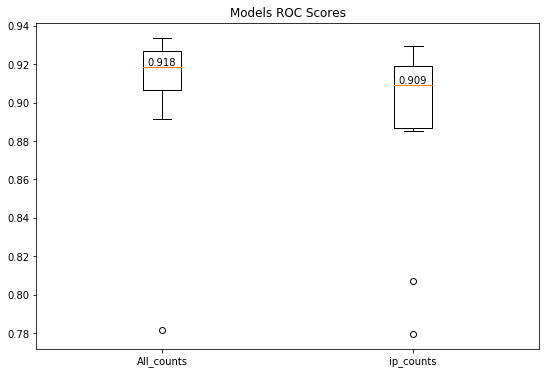

In [18]:
# Ploting the ROC scores
roc_ipcounts = np.array(roc_ipcounts)
data_plot = [roc_counts, roc_ipcounts]
labels = ['All_counts', 'ip_counts']

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

bp_dict = ax.boxplot(data_plot)
ax.set_xticklabels(labels)
ax.set_title('Models ROC Scores')

for line in bp_dict['medians']:
    # get position data for median line
    x1, y1 = line.get_xydata()[0] # low of median line
    x2, y1 = line.get_xydata()[1] # top of median line
    x = (x1 + x2)/2
    # overlay median value
    text(x, y1+0.001, '%.3f' % y1,
         horizontalalignment='center') # draw above, centered

Observamos que, apesar da mediana do modelo mais parcimonioso não estar muito distante do modelo completo, a variância dos resultados aumentou bastante. Seguimos Tentando novas features.

# 2. Utilizando a informação temporal

Criaremos uma coluna que mede o intervalo entre um clique e outro ligado ao mesmo IP

In [19]:
# This cell takes a long time to run.... be pacient
start_time = time.time()
gr = pd.DataFrame()
gr['ip'] = df_merge.ip
gr['time'] = pd.to_datetime(df_merge.loc[:,['hours', 'minutes', 'seconds']].astype(str).apply(''.join,1),format='%H%M%S')
gr['delta_time'] = gr.groupby('ip').time.diff().dt.total_seconds()
gr = gr.drop(['time'], axis=1)
print('New dataframe with diff clicktime created in {} seconds'.format(round(time.time() - start_time), 3))

New dataframe with diff clicktime created in 1793 seconds


In [21]:
#Merging the new feature created in the original df
df_merge['delta_time'] = gr.delta_time
df_merge['delta_time'] = df_merge['delta_time'].fillna(value = 0)
# Deleting the temporary df created on the process
del gr
gc.collect();

df_merge.head()

,ip,app,device,os,channel,days,hours,minutes,seconds,ip_count,app_count,os_count,channel_count,delta_time
0,29045,64,1,13,459,6,14,54,59,1472,58544,8424,55595,0.0
1,64886,3,1,13,379,6,15,5,17,1702,18901,8424,24734,0.0
2,147605,3,1,19,379,6,15,8,24,559,18901,32993,24734,0.0
3,108881,3,1,19,379,6,15,25,15,19887,18901,32993,24734,0.0
4,116013,3,1,13,379,6,15,39,18,948,18901,8424,24734,0.0


In [22]:
# Getting back train and test
df_train = df_merge[:train_record_index]
df_test = df_merge[train_record_index:]

In [23]:
# Doing undersampling

rus = RandomUnderSampler(return_indices=True)
X_resampled, Y_resampled, idx_resampled = rus.fit_sample(df_train, Learning_Y)

X_resampled = pd.DataFrame(X_resampled, columns=df_train.columns)
Y_resampled = pd.DataFrame(Y_resampled, columns=['is_attributed'])

In [24]:
# Separating 10 groups of testing and training for cross validation

train_idx = np.array([])
test_idx = np.array([])
roc_ipcounts_dtime = []

idx = model_selection.StratifiedKFold(n_splits=10).split(X_resampled, Y_resampled)

In [25]:
for train_idx, test_idx in idx:
    start_time = time.time()
    X = X_resampled.iloc[train_idx]
    Y = Y_resampled.iloc[train_idx]
    rf = RandomForestClassifier(n_estimators=100, max_depth=13, verbose=0, n_jobs = -1)
    rf = rf.fit(X, Y.values.ravel())
    
    print('RandomForest has fitted X_resampled with {} seconds'.format(round(time.time() - start_time), 3))
        
    Y_true = Y_resampled.iloc[test_idx]
    Y_pred = rf.predict(X_resampled.iloc[test_idx])
    roc_ipcounts_dtime.append(roc_auc_score(Y_true, Y_pred))

RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 1 seconds
RandomForest has fitted X_resampled with 1 seconds


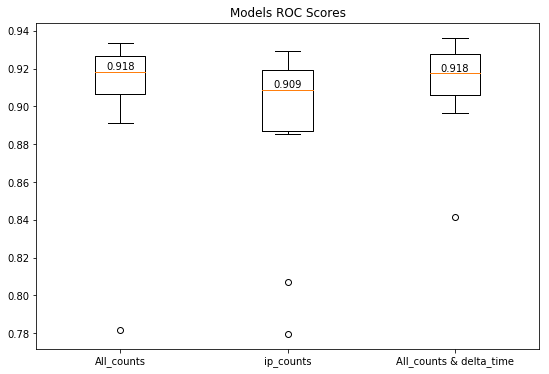

In [26]:
# Ploting the ROC scores
roc_counts_dtime = np.array(roc_ipcounts_dtime)
data_plot = [roc_counts, roc_ipcounts, roc_counts_dtime]
labels = ['All_counts', 'ip_counts', 'All_counts & delta_time']

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

bp_dict = ax.boxplot(data_plot)
ax.set_xticklabels(labels)
ax.set_title('Models ROC Scores')

for line in bp_dict['medians']:
    # get position data for median line
    x1, y1 = line.get_xydata()[0] # low of median line
    x2, y1 = line.get_xydata()[1] # top of median line
    x = (x1 + x2)/2
    # overlay median value
    text(x, y1+0.001, '%.3f' % y1,
         horizontalalignment='center') # draw above, centered

As novas alterações propostas não provocaram grandes mudanças na capacidade preditiva do modelo.

# 3. Usando apenas nossas features

Seguindo a filosofia da parimonia, tentaremos reduzir o número de features usadas no treinamento do modelo e avaliar como isso afeta sua eficiência

In [27]:
# Doing undersampling
params = ['device', 'hours', 'minutes', 'seconds', 'ip_count', 'app_count', 'os_count', 'channel_count', 'delta_time']
rus = RandomUnderSampler(return_indices=True)
X_resampled, Y_resampled, idx_resampled = rus.fit_sample(df_train[params], Learning_Y)

X_resampled = pd.DataFrame(X_resampled, columns=params)
Y_resampled = pd.DataFrame(Y_resampled, columns=['is_attributed'])

In [28]:
# Separating 10 groups of testing and training for cross validation

train_idx = np.array([])
test_idx = np.array([])
roc_onlycounts_dtime = []

idx = model_selection.StratifiedKFold(n_splits=10).split(X_resampled, Y_resampled)

In [29]:
for train_idx, test_idx in idx:
    start_time = time.time()
    X = X_resampled.iloc[train_idx]
    Y = Y_resampled.iloc[train_idx]
    rf = RandomForestClassifier(n_estimators=100, max_depth=20, verbose=0, n_jobs = -1)
    rf = rf.fit(X, Y.values.ravel())
    
    print('RandomForest has fitted X_resampled with {} seconds'.format(round(time.time() - start_time), 3))
        
    Y_true = Y_resampled.iloc[test_idx]
    Y_pred = rf.predict(X_resampled.iloc[test_idx])
    roc_onlycounts_dtime.append(roc_auc_score(Y_true, Y_pred))

RandomForest has fitted X_resampled with 2 seconds
RandomForest has fitted X_resampled with 2 seconds
RandomForest has fitted X_resampled with 2 seconds
RandomForest has fitted X_resampled with 2 seconds
RandomForest has fitted X_resampled with 2 seconds
RandomForest has fitted X_resampled with 2 seconds
RandomForest has fitted X_resampled with 2 seconds
RandomForest has fitted X_resampled with 2 seconds
RandomForest has fitted X_resampled with 2 seconds
RandomForest has fitted X_resampled with 2 seconds


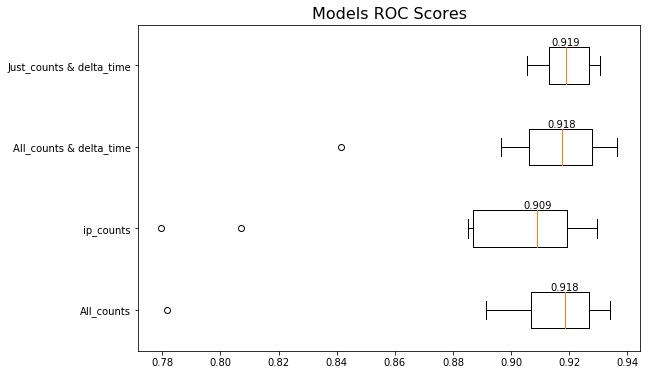

In [30]:
# Ploting the ROC scores
roc_onlycounts_dtime = np.array(roc_onlycounts_dtime)
data_plot = [roc_counts, roc_ipcounts, roc_counts_dtime, roc_onlycounts_dtime]
labels = ['All_counts', 'ip_counts', 'All_counts & delta_time', 'Just_counts & delta_time']

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)

bp_dict = ax.boxplot(data_plot, vert=False)
ax.set_yticklabels(labels)
ax.set_title('Models ROC Scores', fontsize = 16)

for line in bp_dict['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # low of median line
        
    # overlay median value
    text(x, y + 0.02, '%.3f' % x,
         horizontalalignment='center') # draw above, centered

Interessante ver que reduzir o número de features usadas no treino do algoritmo também reduz a variância dos ROC scores

# 4. Submissão

Preparando os datasets para submissão

In [31]:
# Predict
print('Starting prediction phase...')
start_time = time.time()
predictions = rf.predict_proba(df_test[params])
print('Prediction done. Elapsed time: {} seconds'.format(round(time.time() - start_time, 3)))

Starting prediction phase...
Prediction done. Elapsed time: 57.439 seconds


In [32]:
# Creating the submission dataset
df_submit['is_attributed'] = predictions[:,1]

print('Submission dataset created.')
df_submit.head()

Submission dataset created.


,click_id,is_attributed
0,0,0.312622
1,1,0.223482
2,2,0.197517
3,3,0.160406
4,4,0.158317


In [185]:
# Preparing submssion
df_submit.to_csv('Undersample_clicktime.csv', index=False)
print('Submission dataset saved correctly.')

df_submit.describe()

Submission dataset saved correctly.


,click_id,is_attributed
count,1.879047e+07,1.879047e+07
mean,9.395234e+06,1.358047e-01
std,5.424341e+06,1.675659e-01
min,0.000000e+00,0.000000e+00
25%,4.697617e+06,4.229510e-02
50%,9.395234e+06,7.976632e-02
75%,1.409285e+07,1.558537e-01
max,1.879047e+07,1.000000e+00
